# PORTFOLIO SIMULATION - MONTECARLO WITH MEAN AND STD

In [1]:
import pandas as pd
import numpy as np

In [2]:
# given the mean and the std of a normal distribution, calculate montecarlo simulations for horizons 60,120,180,240, and return a DataFrame with the data
def generate_montecarlo_from_normal(mean, std, n_simulations=1000):
    # rendimento mensilizzato
    mean = (1 + mean) ** (1/12) - 1  # convert annual to monthly
    std = std / np.sqrt(12)  # convert annual std to monthly std
    horizons = [60, 120, 180, 240, 360]
    results = {horizon: [] for horizon in horizons}

    for horizon in horizons:
        # Simula i rendimenti per ogni orizzonte temporale e crea un dataframe per ogni simulazione
        for _ in range(n_simulations):
            # Genera rendimenti normali per l'orizzonte specificato
            simulated_returns = np.random.normal(loc=mean, scale=std, size=horizon)
            # Calcola il rendimento cumulativo
            results[horizon].append(pd.DataFrame(simulated_returns))

    return results

normal_portfolios = generate_montecarlo_from_normal(0.0848, 0.0898, n_simulations=10000)


In [3]:
# for each simulation calculate the cumulative returns
def calculate_cumulative_returns(simulations):
    cumulative_returns = {}
    for horizon, sim_list in simulations.items():
        cum_returns = []
        for sim in sim_list:
            cum_return = (1 + sim).cumprod() - 1  # Calcola i rendimenti cumulativi
            cum_returns.append(cum_return)
        cumulative_returns[horizon] = cum_returns
    return cumulative_returns

def analyze_simulations(simulations):
    final_returns_list = []
    variances_list = []

    for sim in simulations:
        # Calcolo del rendimento cumulativo per ogni asset (log → somma, altrimenti moltiplica)
        cumulative = (1 + sim).sum() - 1  # se usi pct_change; usa .sum() se hai log-returns
        variance = sim.std()  # varianza su tutti i mesi

        final_returns_list.append(cumulative)
        variances_list.append(variance)

    # Combina i risultati in DataFrame
    final_returns_df = pd.DataFrame(final_returns_list)
    variances_df = pd.DataFrame(variances_list)

    # Rendimento medio finale e varianza media su tutte le simulazioni
    mean_final_return = final_returns_df.mean()
    mean_variance = variances_df.mean()

    return mean_final_return, mean_variance

def max_drawdown(rets_df, initial_value=100):
    # 1. Calcola indice di ricchezza cumulato (wealth index)
    wealth = (1 + rets_df).cumprod() * initial_value

    # 2. Calcola picco cumulativo (running max)
    running_max = wealth.cummax()

    # 3. Calcola drawdown in ogni istante
    drawdown = wealth / running_max - 1

    # 4. Massimo drawdown (più negativo) per asset
    mdd = drawdown.min()

    return mdd


def summarize_simulations(simulations, months, use_log_returns=False):
    final_returns = []
    variances = []
    max_drawdowns = []

    for sim in simulations:
        if use_log_returns:
            cumulative_return = np.exp(sim.sum()) - 1
        else:
            cumulative_return = (1 + sim).prod() - 1

        variance = sim.std()

        ## annualizza il rendimento cumulativo e la varianza
        cumulative_return_annualized = (1 + cumulative_return) ** (12 / months) - 1
        variance_annualized = variance
        mdd = max_drawdown(sim)

        final_returns.append(cumulative_return_annualized)
        variances.append(variance_annualized)
        max_drawdowns.append(mdd)

    # Costruisci i DataFrame
    final_returns_df = pd.DataFrame(final_returns)    # ogni riga = 1 simulazione
    variances_df = pd.DataFrame(variances)
    max_drawdowns_df = pd.DataFrame(max_drawdowns)

    return final_returns_df, variances_df, max_drawdowns_df

def horizon_summary(montecarlo_simulations, horizon_list=[60, 120, 180, 240, 360], use_log_returns=False):
    rows = []

    for horizon in horizon_list:
        ret_df, var_df, mdd_df = summarize_simulations(montecarlo_simulations[horizon], horizon, use_log_returns=use_log_returns)

        # Calcola il ritorno finale
        final_df = (1 + ret_df) ** (horizon / 12) - 1

        for sigma in [0.025, 0.15, 0.5, 0.7, 0.95]:
            # find the index of the simulation that corresponds to the sigma quantile
            # Calcola il quantile su ret_df
            quantile_value = ret_df.quantile(sigma).item()  # ottieni lo scalare

            # Trova l'indice della riga più vicina
            closest_index = (ret_df.iloc[:, 0] - quantile_value).abs().idxmin()


            # usa questo indice per ottenere i dati di final, variance e mdd


            summary = {
                "horizon_sigma": f"{horizon}_{sigma}",
                "return": ret_df.loc[closest_index].item(),
                "final": final_df.loc[closest_index].item(),
                "variance": var_df.loc[closest_index].item(),
                "mdd": mdd_df.loc[closest_index].item()
            }

            rows.append(summary)

    # Crea il DataFrame finale
    tot_summary = pd.DataFrame(rows).set_index("horizon_sigma")

    return tot_summary

summ_normal = horizon_summary(normal_portfolios, use_log_returns= False)
summ_normal

,return,final,variance,mdd
horizon_sigma,,,,
60_0.025,-0.000936,-0.004674,0.023876,-0.226837
60_0.15,0.035851,0.192577,0.025567,-0.095923
60_0.5,0.080571,0.473213,0.027487,-0.140985
60_0.7,0.103365,0.635297,0.024571,-0.091315
60_0.95,0.152707,1.035143,0.024723,-0.053224
120_0.025,0.022652,0.251066,0.027210,-0.214085
120_0.15,0.049418,0.619896,0.027396,-0.187217
120_0.5,0.080277,1.164466,0.023482,-0.084888
120_0.7,0.096361,1.509198,0.023934,-0.092787


# Portfolio Simulation - Montecarlo WITH Bootstrap

In [4]:
portfolios_weights = [
    {"name": "MSCI-World", "composition": [("msci-world", 1)]},
    {"name": "60-40", "composition": [("msci-world", 0.6), ("bond-7-10", 0.4)]},
    {"name": "All-Weather World", "composition": [("msci-world", 0.6), ("bond-7-10", 0.2), ("gold", 0.1), ("cash", 0.1)]},
    {"name": "All-Weather + EIMI", "composition": [("msci-world", 0.5), ("msci-world-em",0.1), ("bond-7-10", 0.2), ("gold", 0.1), ("cash", 0.1)]},
    {"name": "Factors", "composition": [("msci-world-momentum", 0.45),("msci-world-min-vol", 0.25), ("bond-7-10", 0.2), ("gold", 0.1)]},
    {"name": "Factors - No Bond", "composition": [("msci-world-momentum", 0.45),("msci-world-min-vol", 0.35), ("gold", 0.1), ("cash", 0.1)]},
    {"name": "Factors + Cash", "composition": [("msci-world-momentum", 0.35),("msci-world-min-vol", 0.25), ("bond-7-10", 0.2), ("gold", 0.1), ("cash", 0.1)]}
]
import pandas as pd
import os
from functools import reduce

def load_asset_data(assets, path="data/csv"):
    asset_data = {}
    for asset in assets:
        file_path = os.path.join(path, f"{asset}.csv")
        df = pd.read_csv(file_path, parse_dates=True, index_col=0)
        df = df.sort_index()
        df = df[df.columns[0]]
        asset_data[asset] = df.rename(asset)
    return asset_data

def align_assets(asset_data):
    return reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how="inner"),
                  asset_data.values())

def compute_monthly_returns(prices_df, log_returns=False):
    if log_returns:
        return np.log(prices_df / prices_df.shift(1)).dropna()
    else:
        return prices_df.pct_change().dropna()


def construct_portfolios(portfolios, asset_returns):
    portfolio_returns = {}

    for portfolio in portfolios:
        name = portfolio["name"]
        composition = portfolio["composition"]

        weights = {asset: weight for asset, weight in composition}

        # check if the sum of the weights is 1
        if not np.isclose(sum(weights.values()), 1.0):
            raise ValueError(f"Weights for portfolio '{name}' do not sum to 1.0")

        df = pd.DataFrame()
        for asset, weight in weights.items():
            df[asset] = asset_returns[asset] * weight

        portfolio_returns[name] = df.sum(axis=1)

    return pd.DataFrame(portfolio_returns)

def prepare_portfolios(portfolios_weights, data_path="data/csv", log_returns=False):
    all_assets = sorted(set(asset for p in portfolios_weights for asset, _ in p["composition"]))
    asset_data = load_asset_data(all_assets, path=data_path)
    aligned_prices = align_assets(asset_data)
    aligned_returns = compute_monthly_returns(aligned_prices, log_returns=log_returns)
    portfolio_returns = construct_portfolios(portfolios_weights, aligned_returns)
    return portfolio_returns, aligned_returns

portfolio_returns, asset_returns = prepare_portfolios(portfolios_weights)


In [5]:
def portfolio_statistics(returns, periods_per_year=12):
    stats = pd.DataFrame(index=returns.columns)

    # 1. Rendimento annualizzato (media geometrica)
    stats["annualized_return"] = (1 + returns.mean()) ** periods_per_year - 1

    # 2. Volatilità annualizzata
    stats["annualized_volatility"] = returns.std() * np.sqrt(periods_per_year)

    # 3. Maximum Drawdown
    cum_returns = (1 + returns).cumprod()
    peak = cum_returns.cummax()
    drawdown = cum_returns / peak - 1
    stats["max_drawdown"] = drawdown.min()

    return stats
portfolio_stats = portfolio_statistics(portfolio_returns)
print(portfolio_stats)




                    annualized_return  annualized_volatility  max_drawdown
MSCI-World                   0.092772               0.138525     -0.487969
60-40                        0.069769               0.088298     -0.279779
All-Weather World            0.074850               0.085135     -0.266294
All-Weather + EIMI           0.071939               0.084543     -0.277971
Factors                      0.090735               0.090399     -0.275959
Factors - No Bond            0.092560               0.097943     -0.325160
Factors + Cash               0.079871               0.077232     -0.226424


In [6]:
def montecarlo_bootstrap(returns, n_simulations=1000, horizon_months=120, log_returns=False, seed=None):
    """
    Simula traiettorie future con bootstrap dei rendimenti storici.
    
    returns: Series (es. un portafoglio)
    log_returns: True = usa somma log, False = usa compounding semplice
    """
    if seed:
        np.random.seed(seed)
        
    returns = returns.dropna().values
    n_obs = len(returns)

    simulations = []

    for _ in range(n_simulations):
        sampled = np.random.choice(returns, size=horizon_months, replace=True)
        
        if log_returns:
            cumulative = np.exp(np.cumsum(sampled))  # da log-rendimenti a valore relativo
        else:
            cumulative = np.cumprod(1 + sampled)

        simulations.append(cumulative)

    return pd.DataFrame(simulations).T  # colonne = simulazioni, righe = mesi

def run_montecarlo_for_portfolios(portfolio_returns, horizons=[60, 120, 180, 240, 360], 
                                   n_simulations=1000, log_returns=False):
    simulations = {}

    for portfolio in portfolio_returns.columns:
        portfolio_simulations = {}
        for h in horizons:
            sim_df = montecarlo_bootstrap(portfolio_returns[portfolio], horizon_months=h,
                                          n_simulations=n_simulations, log_returns=log_returns)
            portfolio_simulations[h] = sim_df
        simulations[portfolio] = portfolio_simulations

    return simulations

simulations = run_montecarlo_for_portfolios(portfolio_returns, horizons=[60, 120, 180, 240, 360], n_simulations=1000)


In [7]:
def calc_max_recovery_time(series):
    peak = series.cummax()
    in_drawdown = series < peak

    recovery_times = []
    count = 0
    for down in in_drawdown:
        if down:
            count += 1
        else:
            if count > 0:
                recovery_times.append(count)
            count = 0
    if count > 0:
        recovery_times.append(count)

    return max(recovery_times) if recovery_times else 0


def summarize_simulations(sim_df, horizon_months):
    """
    sim_df: DataFrame con simulazioni (righe = mesi, colonne = simulazioni)
    """
    final_vals = sim_df.iloc[-1]
    ann_returns = final_vals ** (12 / horizon_months) - 1

    stats = {}

    for q in ["mean", 0.0, 0.025]:
        if q == "mean":
            col = ann_returns.mean()
            # prendi la colonna più vicina alla media
            sim_id = (ann_returns - col).abs().idxmin()
        else:
            target = ann_returns.quantile(q)
            sim_id = (ann_returns - target).abs().idxmin()

        sim = sim_df[sim_id]

        # Ritorno annualizzato (già calcolato sopra)
        final_val = sim.iloc[-1]
        ann_return = final_val ** (12 / horizon_months) - 1

        # Std annualizzata
        monthly_ret = sim.pct_change().dropna()
        ann_std = monthly_ret.std() * np.sqrt(12)

        # Maximum Drawdown
        cum = sim
        peak = cum.cummax()
        dd = (cum / peak - 1).min()

        recovery_times = [calc_max_recovery_time(sim_df[col]) for col in sim_df.columns]
        # compute the mean of the recovery times
        recovery_time = np.mean(recovery_times) if q == "mean" else calc_max_recovery_time(sim)

        stats[str(q)] = {
            "return": ann_return,
            "std": ann_std,
            "mdd": dd,
            "recovery_time": recovery_time
        }
    # compute the 0.05 quantile of the MDD
    all_mdds = []

    for col in sim_df.columns:
        sim = sim_df[col]
        peak = sim.cummax()
        dd = (sim / peak - 1).min()
        all_mdds.append(dd)

    stats["max_mdd_0.05"] = {
        "return": np.nan,
        "std": np.nan,
        "mdd": pd.Series(all_mdds).quantile(0.0)
    }


    return pd.DataFrame(stats).T

def summarize_all(simulations):
    records = []

    for portfolio, horizons in simulations.items():
        for h, sim_df in horizons.items():
            stats_df = summarize_simulations(sim_df, horizon_months=h)
            stats_df["portfolio"] = portfolio
            stats_df["horizon"] = h
            stats_df["quantile"] = stats_df.index
            records.append(stats_df.reset_index(drop=True))

    return pd.concat(records).set_index(["portfolio", "horizon", "quantile"])

def summarize_all_wide(simulations):
    records = []

    for portfolio, horizons in simulations.items():
        for h, sim_df in horizons.items():
            stats_df = summarize_simulations(sim_df, horizon_months=h)
            # stats_df ha indice quantile e colonne return,std,mdd

            # Costruiamo un dict che concatena le colonne con quantile nel nome
            flat_dict = {}
            for quantile in stats_df.index:
                for metric in stats_df.columns:
                    flat_dict[f"{metric}_{quantile}"] = stats_df.loc[quantile, metric]

            flat_dict["portfolio"] = portfolio
            flat_dict["horizon"] = h

            records.append(flat_dict)

    return pd.DataFrame(records).set_index(["portfolio", "horizon"])


summary_df = summarize_all_wide(simulations)
summary_df

return_mean  std_mean  mdd_mean  \
portfolio          horizon                                    
MSCI-World         60          0.085890  0.137436 -0.213150   
                   120         0.084745  0.129116 -0.268081   
                   180         0.085592  0.135238 -0.219922   
                   240         0.082147  0.145880 -0.348159   
                   360         0.081881  0.145800 -0.281530   
60-40              60          0.066174  0.089600 -0.099506   
                   120         0.066155  0.099363 -0.203866   
                   180         0.065887  0.095034 -0.203927   
                   240         0.066362  0.081022 -0.240469   
                   360         0.065966  0.087010 -0.133029   
All-Weather World  60          0.073187  0.089888 -0.171821   
                   120         0.071552  0.084049 -0.126084   
                   180         0.071691  0.085872 -0.187185   
                   240         0.071639  0.090969 -0.171241   
                   360         0.071204  0.085829 -0.210935   
All-Weather + EIMI 60          0.070427  0.075266 -0.160373   
                   120         0.067012  0.071362 -0.133157   
                   180         0.067332  0.077129 -0.129150   
                   240         0.067474  0.084390 -0.235343   
                   360         0.068640  0.091100 -0.245597   
Factors            60          0.084732  0.086902 -0.097815   
                   120         0.086455  0.094564 -0.137144   
                   180         0.084646  0.081452 -0.111168   
                   240         0.086377  0.090362 -0.272251   
                   360         0.087249  0.095457 -0.171399   
Factors - No Bond  60          0.087140  0.101406 -0.191194   
                   120         0.088506  0.098847 -0.120726   
                   180         0.088425  0.099643 -0.110808   
                   240         0.086170  0.092069 -0.161340   
                   360         0.086359  0.090498 -0.155073   
Factors + Cash     60          0.079192  0.077180 -0.081238   
                   120         0.076088  0.074024 -0.079731   
                   180         0.076581  0.074068 -0.082881   
                   240         0.077241  0.071785 -0.099411   
                   360         0.076686  0.083271 -0.130290   

                            recovery_time_mean  return_0.0   std_0.0  \
portfolio          horizon                                             
MSCI-World         60                   22.379   -0.133501  0.157007   
                   120                  37.780   -0.071047  0.145308   
                   180                  48.076   -0.025775  0.146240   
                   240                  59.932   -0.026741  0.150365   
                   360                  73.612   -0.004867  0.139696   
60-40              60                   19.848   -0.053740  0.106612   
                   120                  32.154   -0.036703  0.090696   
                   180                  40.647   -0.024237  0.099223   
                   240                  46.590    0.000392  0.091887   
                   360                  56.173    0.003092  0.092346   
All-Weather World  60                   19.048   -0.058306  0.078502   
                   120                  28.249   -0.028473  0.085862   
                   180                  34.693   -0.009306  0.098295   
                   240                  40.228    0.014469  0.085739   
                   360                  48.098    0.025553  0.086240   
All-Weather + EIMI 60                   18.621   -0.056932  0.085904   
                   120                  30.407   -0.022593  0.090094   
                   180                  36.495   -0.014243  0.096070   
                   240                  43.904    0.004932  0.093709   
                   360                  50.751    0.016125  0.087482   
Factors            60                   17.487   -0.042485  0.098795   
                   120                  

In [8]:
summary_60 = summary_df.xs(360, level='horizon')
summary_60

,return_mean,std_mean,mdd_mean,recovery_time_mean,return_0.0,std_0.0,mdd_0.0,recovery_time_0.0,return_0.025,std_0.025,mdd_0.025,recovery_time_0.025,return_max_mdd_0.05,std_max_mdd_0.05,mdd_max_mdd_0.05,recovery_time_max_mdd_0.05
portfolio,,,,,,,,,,,,,,,,
MSCI-World,0.081881,0.145800,-0.281530,73.612,-0.004867,0.139696,-0.593090,242.0,0.026405,0.144961,-0.413212,100.0,NaN,NaN,-0.689507,NaN
60-40,0.065966,0.087010,-0.133029,56.173,0.003092,0.092346,-0.364318,194.0,0.031797,0.086806,-0.288236,142.0,NaN,NaN,-0.445338,NaN
All-Weather World,0.071204,0.085829,-0.210935,48.098,0.025553,0.086240,-0.310169,101.0,0.039161,0.087802,-0.212272,55.0,NaN,NaN,-0.488846,NaN
All-Weather + EIMI,0.068640,0.091100,-0.245597,50.751,0.016125,0.087482,-0.388203,248.0,0.036017,0.091014,-0.275756,138.0,NaN,NaN,-0.535180,NaN
Factors,0.087249,0.095457,-0.171399,40.817,0.029158,0.089708,-0.383339,121.0,0.050732,0.092364,-0.220681,35.0,NaN,NaN,-0.393072,NaN
Factors - No Bond,0.086359,0.090498,-0.155073,46.444,0.034684,0.098737,-0.278289,77.0,0.049288,0.098004,-0.290145,85.0,NaN,NaN,-0.490524,NaN
Factors + Cash,0.076686,0.083271,-0.130290,40.187,0.020972,0.076778,-0.250580,133.0,0.046956,0.077743,-0.355380,145.0,NaN,NaN,-0.374949,NaN


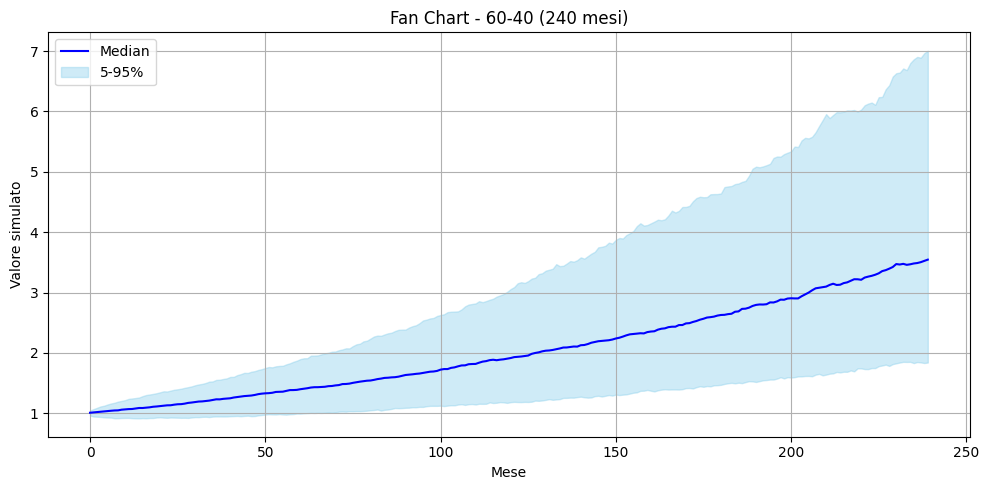

In [9]:
import matplotlib.pyplot as plt

def plot_fan_chart(sim_df, portfolio_name, horizon_months):
    """
    sim_df: una simulazione per un portafoglio e orizzonte
    """
    median = sim_df.median(axis=1)
    q05 = sim_df.quantile(0.05, axis=1)
    q95 = sim_df.quantile(0.95, axis=1)

    plt.figure(figsize=(10, 5))
    plt.plot(median, label="Median", color="blue")
    plt.fill_between(sim_df.index, q05, q95, color="skyblue", alpha=0.4, label="5-95%")

    plt.title(f"Fan Chart - {portfolio_name} ({horizon_months} mesi)")
    plt.xlabel("Mese")
    plt.ylabel("Valore simulato")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_fan_chart(simulations["60-40"][240], "60-40", 240)


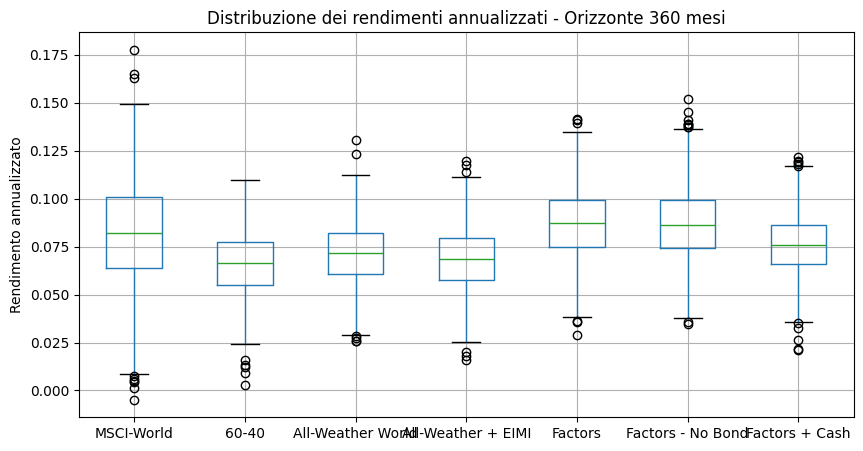

In [10]:
def plot_return_boxplot(simulations, horizon):
    data = {}

    for portfolio in simulations:
        sim_df = simulations[portfolio][horizon]
        final_vals = sim_df.iloc[-1]
        ann_ret = final_vals ** (12 / horizon) - 1
        data[portfolio] = ann_ret

    pd.DataFrame(data).boxplot(figsize=(10, 5))
    plt.title(f"Distribuzione dei rendimenti annualizzati - Orizzonte {horizon} mesi")
    plt.ylabel("Rendimento annualizzato")
    plt.grid(True)
    plt.show()
plot_return_boxplot(simulations, 360)


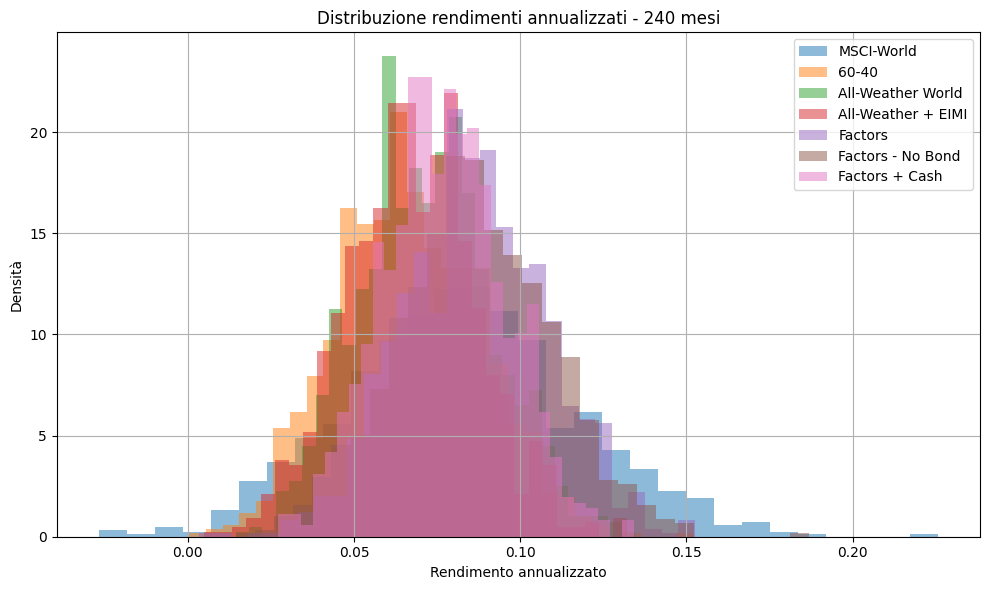

In [11]:
import matplotlib.pyplot as plt

def plot_return_hist(simulations, horizon, bins=30):
    """
    simulations: dict[portfolio][horizon] -> DataFrame simulazioni
    horizon: orizzonte in mesi es. 60
    """
    plt.figure(figsize=(10,6))
    for portfolio, d in simulations.items():
        final_vals = d[horizon].iloc[-1]
        ann_ret = final_vals ** (12 / horizon) - 1
        plt.hist(ann_ret, bins=bins, alpha=0.5, label=portfolio, density=True)

    plt.title(f"Distribuzione rendimenti annualizzati - {horizon} mesi")
    plt.xlabel("Rendimento annualizzato")
    plt.ylabel("Densità")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_return_hist(simulations, horizon=240)


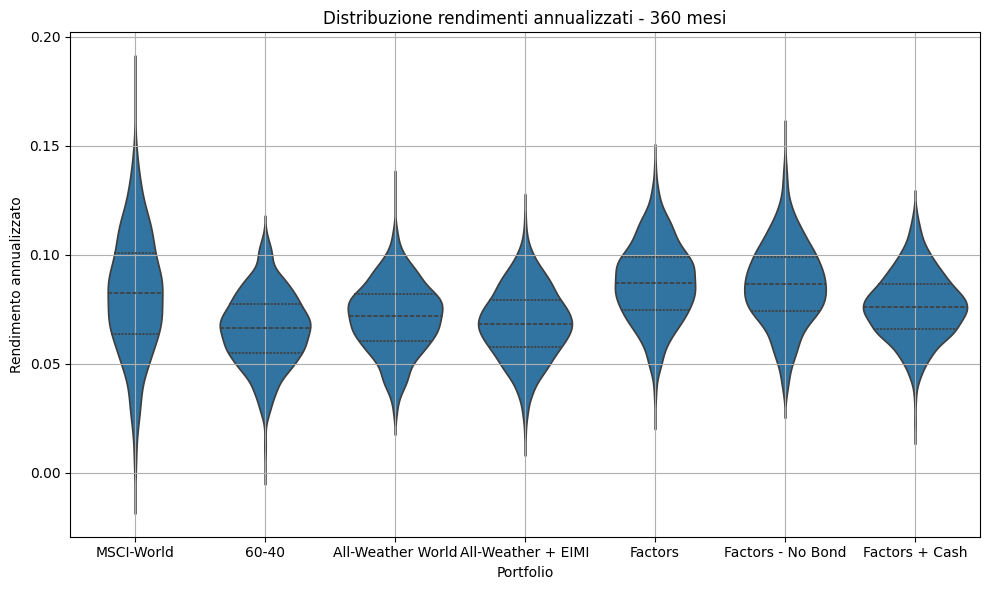

In [14]:
import seaborn as sns

def plot_return_violin(simulations, horizon):
    data = []
    for portfolio, d in simulations.items():
        final_vals = d[horizon].iloc[-1]
        ann_ret = final_vals ** (12 / horizon) - 1
        for val in ann_ret:
            data.append({"portfolio": portfolio, "return": val})
    df = pd.DataFrame(data)

    plt.figure(figsize=(10,6))
    sns.violinplot(x='portfolio', y='return', data=df, inner="quartile")
    plt.title(f"Distribuzione rendimenti annualizzati - {horizon} mesi")
    plt.ylabel("Rendimento annualizzato")
    plt.xlabel("Portfolio")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"violin_plot_{horizon}.png")
    plt.show()
    ## store the image

plot_return_violin(simulations, horizon=360)

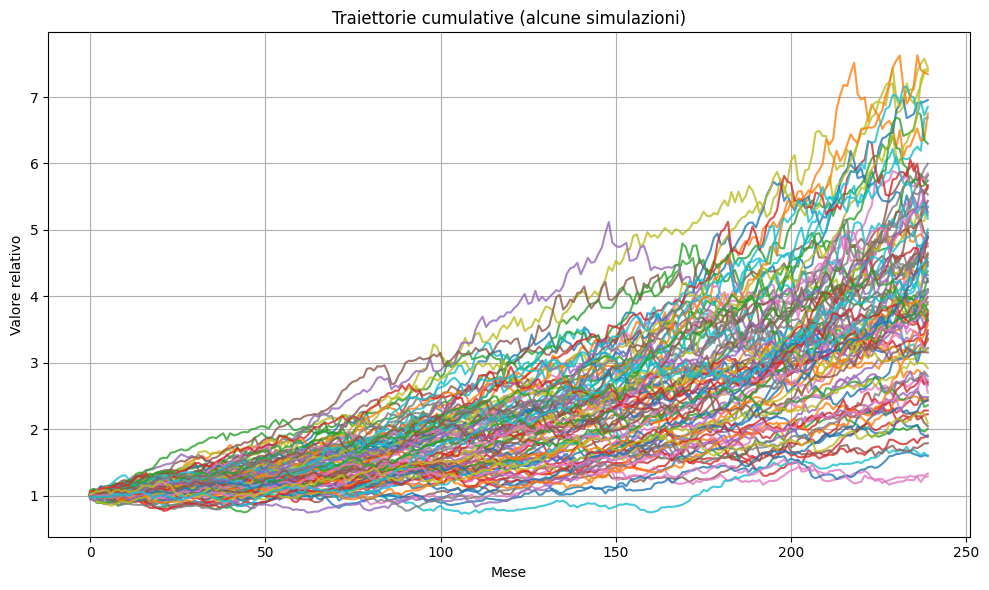

In [148]:
def plot_cumulative_paths(sim_df, num_paths=1000):
    """
    Visualizza num_paths traiettorie casuali su sim_df
    """
    sampled = sim_df.sample(n=min(num_paths, sim_df.shape[1]), axis=1)
    plt.figure(figsize=(10,6))
    for col in sampled:
        plt.plot(sampled[col], alpha=0.8)
    plt.title("Traiettorie cumulative (alcune simulazioni)")
    plt.xlabel("Mese")
    plt.ylabel("Valore relativo")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_cumulative_paths(simulations["60-40"][240], num_paths=100)